In [ ]:
import pandas as pd
import numpy as np
import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer

from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
import tensorflow as tf
print ("Done")

Done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ravdess = "/content/drive/MyDrive/audio_speech_actors_01-24"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

['Actor_15', 'Actor_24', 'Actor_22', 'Actor_17', 'Actor_23', 'Actor_19', 'Actor_16', 'Actor_18', 'Actor_21', 'Actor_20', 'Actor_08', 'Actor_13', 'Actor_05', 'Actor_09', 'Actor_11', 'Actor_10', 'Actor_06', 'Actor_12', 'Actor_07', 'Actor_14', 'Actor_01', 'Actor_04', 'Actor_02', 'Actor_03']


In [ ]:
file_emotion = []
file_path = []

for dir in ravdess_directory_list:
    actor = os.listdir(os.path.join(ravdess, dir))
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_path.append(os.path.join(ravdess, dir, file))

In [ ]:
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

In [ ]:
Ravdess_df.Emotions.replace({1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,angry,/content/drive/MyDrive/audio_speech_actors_01-...
1,neutral,/content/drive/MyDrive/audio_speech_actors_01-...
2,fear,/content/drive/MyDrive/audio_speech_actors_01-...
3,angry,/content/drive/MyDrive/audio_speech_actors_01-...
4,calm,/content/drive/MyDrive/audio_speech_actors_01-...


In [ ]:
print(Ravdess_df.Emotions.value_counts())

angry       192
fear        192
calm        192
happy       192
sad         192
surprise    192
disgust     192
neutral      96
Name: Emotions, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

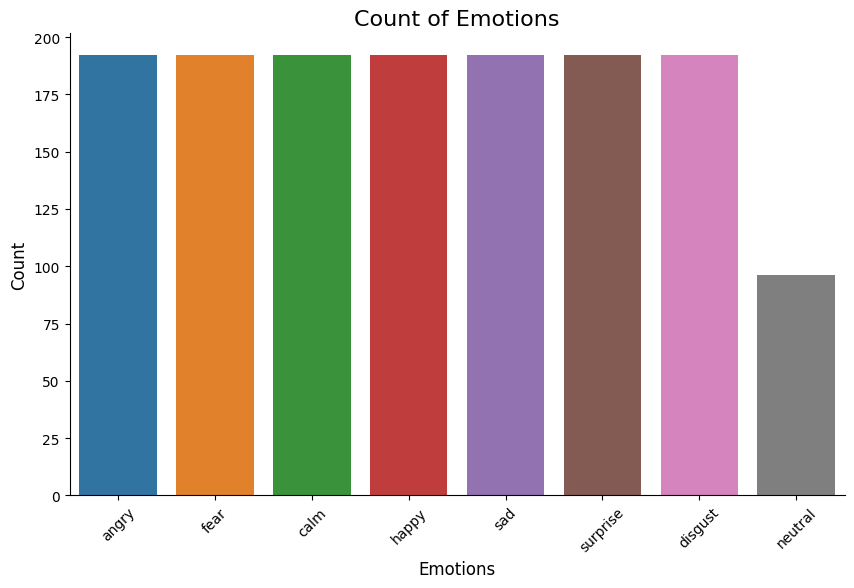

In [ ]:
emotion_counts = Ravdess_df['Emotions'].value_counts()
plt.figure(figsize=(10, 6))
plt.title('Count of Emotions', size=16)
sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.xticks(rotation=45)
sns.despine(top=True, right=True, left=False, bottom=False)

In [ ]:
data_array, sample_rate = librosa.load(Ravdess_df['Path'].iloc[0])
sample_rate

22050

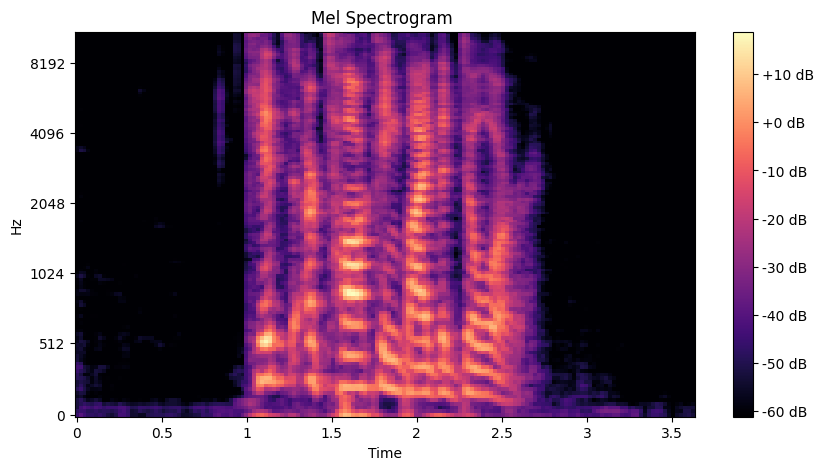

In [ ]:
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data_array, sr=sample_rate, n_mels=128,fmax=5000)
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sample_rate, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')

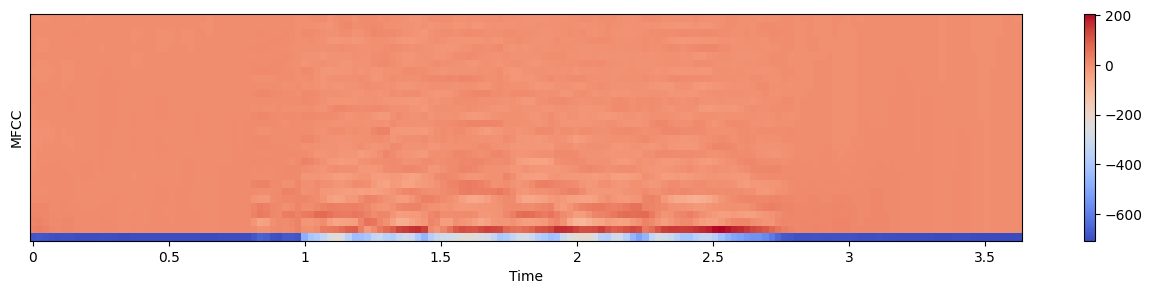

In [ ]:
mfcc = librosa.feature.mfcc(y=data_array, sr=sample_rate, n_mfcc=30)
# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()
ipd.Audio(data_array,rate=sample_rate)

In [ ]:
def noise(data):
    noise_amp = 0.045*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data


def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data,rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

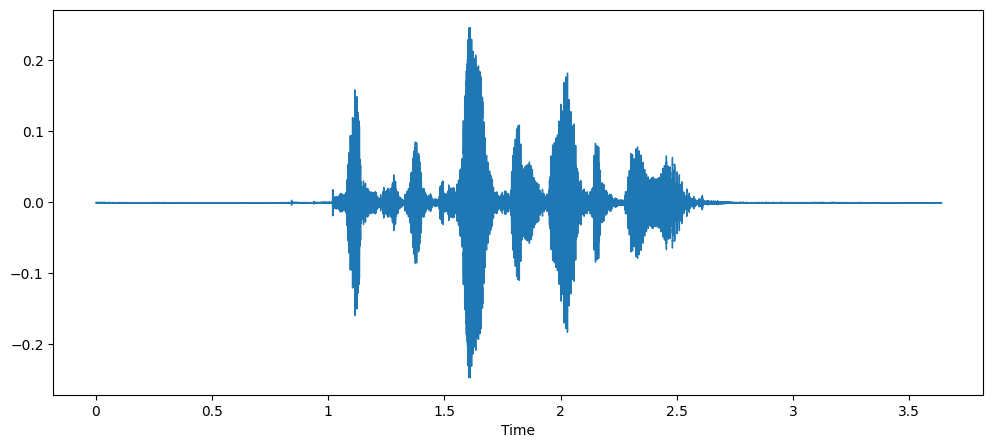

In [ ]:
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data_array, sr=sample_rate)
ipd.Audio(data_array,rate=sample_rate)

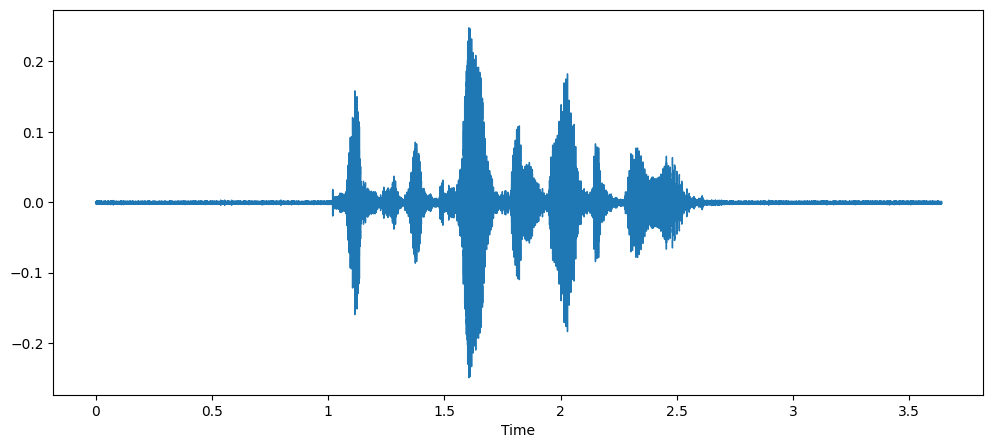

In [ ]:
x = noise(data_array)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

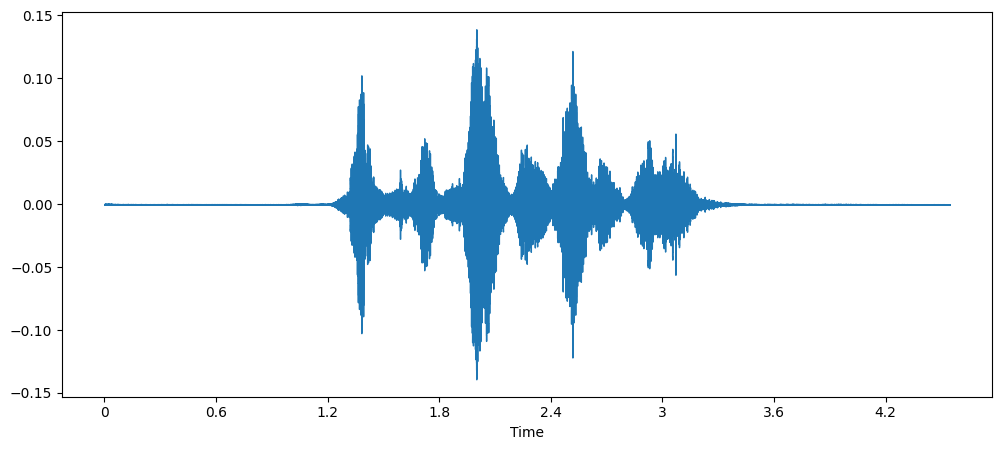

In [ ]:
x = stretch(data_array)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

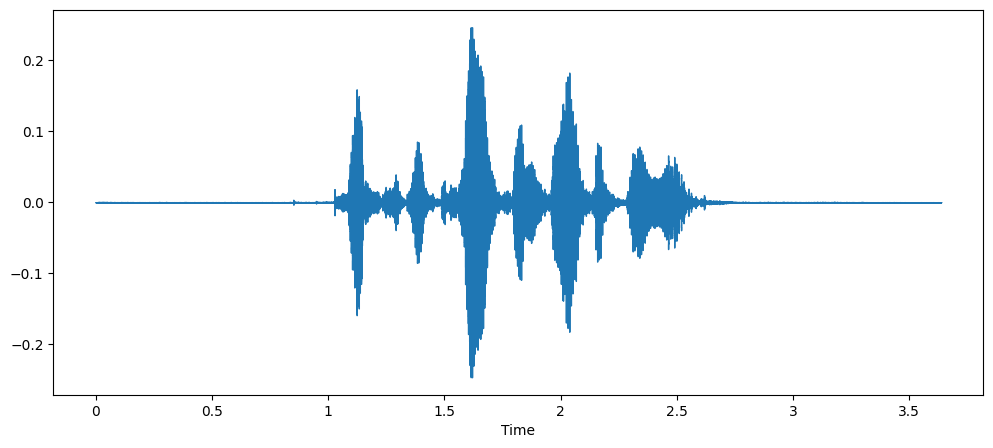

In [ ]:
x = shift(data_array)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

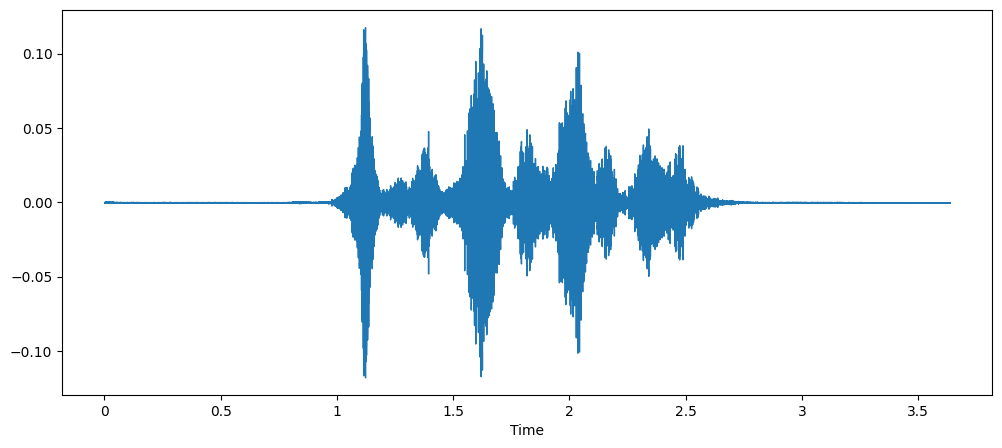

In [ ]:
x = pitch(data=data_array,sampling_rate=sample_rate)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

In [ ]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
# hàm tính root mean square error
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
#mfcc
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path = path,duration=duration,offset=offset)
    aud=extract_features(data) # trích xuất feature
    audio=np.array(aud) # chuyển các feature thành array

    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))

    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))

    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))

    return audio

In [ ]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  2


In [ ]:
from joblib import Parallel, delayed
import timeit
start = timeit.default_timer()

def process_feature(path, emotion):
    features = get_features(path)
    X = []
    Y = []
    for ele in features:
        X.append(ele)
        Y.append(emotion)
    return X, Y

paths = Ravdess_df.Path
emotions = Ravdess_df.Emotions


results = Parallel(n_jobs=-1)(delayed(process_feature)(path, emotion) for (path, emotion) in zip(paths, emotions))

X = []
Y = []
for result in results:
    x, y = result
    X.extend(x)
    Y.extend(y)


stop = timeit.default_timer()

print('Time: ', stop - start)

Time:  386.081233052


In [ ]:
len(X), len(Y), Ravdess_df.Path.shape

(5760, 5760, (1440,))

In [ ]:
emotions = pd.DataFrame(X)
emotions['Emotions'] = Y
emotions.to_csv('emotion.csv', index=False)
emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.199707,0.310547,0.404785,0.366699,0.332031,0.305176,0.305176,0.291504,0.272949,0.235840,...,7.736185,6.963674,6.227290,5.530825,4.876470,4.265867,3.701142,3.185372,2.722908,angry
1,0.253418,0.384277,0.513672,0.501953,0.492676,0.488770,0.486816,0.491699,0.503418,0.501953,...,-4.927268,-1.002781,-0.107281,-2.077633,2.659267,3.983085,0.905676,1.106793,-2.010822,angry
2,0.119141,0.151855,0.172363,0.112793,0.076660,0.055664,0.051270,0.076172,0.097168,0.141113,...,6.058433,5.681841,5.303742,4.921478,4.532805,4.136860,3.734959,3.330902,2.931012,angry
3,0.240723,0.367188,0.489258,0.499512,0.499023,0.507812,0.504883,0.501465,0.498535,0.472168,...,0.199620,0.346138,0.059873,-0.736507,1.553938,3.542849,2.084498,-7.406546,-8.484363,angry
4,0.287109,0.425781,0.524902,0.567383,0.507812,0.442871,0.463867,0.352051,0.253418,0.194336,...,11.625010,11.843138,11.167751,9.961384,8.978588,8.592356,8.438915,7.830766,6.505079,neutral


In [ ]:
Emotions = pd.read_csv('emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.199707,0.310547,0.404785,0.366699,0.332031,0.305176,0.305176,0.291504,0.272949,0.235840,...,7.736185,6.963674,6.227290,5.530825,4.876470,4.265867,3.701142,3.185372,2.722908,angry
1,0.253418,0.384277,0.513672,0.501953,0.492676,0.488770,0.486816,0.491699,0.503418,0.501953,...,-4.927268,-1.002781,-0.107281,-2.077633,2.659267,3.983085,0.905676,1.106793,-2.010822,angry
2,0.119141,0.151855,0.172363,0.112793,0.076660,0.055664,0.051270,0.076172,0.097168,0.141113,...,6.058433,5.681841,5.303742,4.921478,4.532805,4.136860,3.734959,3.330902,2.931012,angry
3,0.240723,0.367188,0.489258,0.499512,0.499023,0.507812,0.504883,0.501465,0.498535,0.472168,...,0.199620,0.346138,0.059873,-0.736507,1.553938,3.542849,2.084498,-7.406546,-8.484363,angry
4,0.287109,0.425781,0.524902,0.567383,0.507812,0.442871,0.463867,0.352051,0.253418,0.194336,...,11.625010,11.843138,11.167751,9.961384,8.978588,8.592356,8.438915,7.830766,6.505079,neutral


In [ ]:
print(Emotions.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [ ]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(5760, 2377)

In [ ]:
np.sum(Emotions.isna())

0           0
1           0
2           0
3           0
4           0
           ..
2372        0
2373        0
2374        0
2375        0
Emotions    0
Length: 2377, dtype: int64

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
sequence_data = Emotions['2375'].values
target_data = Emotions['Emotions'].values

In [ ]:
encoder = OneHotEncoder(sparse=False)
target_data = encoder.fit_transform(target_data.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sequence_data, target_data, test_size=0.2, random_state=42)

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, 1))
X_test = scaler.transform(X_test.reshape(-1, 1))

In [ ]:
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], 1), activation='relu'))
model.add(Dense(1))

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
144/144 [==============================] - 2s 5ms/step - loss: 0.1094 - val_loss: 0.1094
Epoch 2/100
144/144 [==============================] - 0s 3ms/step - loss: 0.1094 - val_loss: 0.1094
Epoch 3/100
144/144 [==============================] - 0s 3ms/step - loss: 0.1094 - val_loss: 0.1094
Epoch 4/100
144/144 [==============================] - 1s 4ms/step - loss: 0.1094 - val_loss: 0.1094
Epoch 5/100
144/144 [==============================] - 2s 11ms/step - loss: 0.1094 - val_loss: 0.1094
Epoch 6/100
144/144 [==============================] - 1s 9ms/step - loss: 0.1094 - val_loss: 0.1094
Epoch 7/100
144/144 [==============================] - 1s 5ms/step - loss: 0.1094 - val_loss: 0.1094
Epoch 8/100
144/144 [==============================] - 1s 5ms/step - loss: 0.1094 - val_loss: 0.1094
Epoch 9/100
144/144 [==============================] - 1s 5ms/step - loss: 0.1094 - val_loss: 0.1094
Epoch 10/100
144/144 [==============================] - 0s 3ms/step - loss: 0.1094 - val_l

In [ ]:
test_loss = model.evaluate(X_test, y_test)
print(f'Test loss: {test_loss}')
test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy}')

36/36 [==============================] - 0s 2ms/step - loss: 0.1094
Test loss: 0.109375
36/36 [==============================] - 0s 2ms/step - loss: 0.1094
Test accuracy: 0.109375


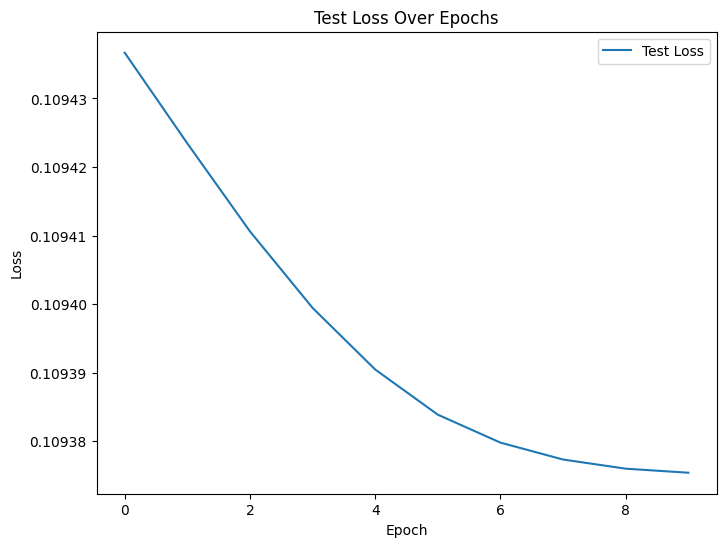

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Test Loss Over Epochs')
plt.show()



In [ ]:
new_data = np.array([0.5])
scaled_data = scaler.transform(new_data.reshape(-1, 1))
prediction = model.predict(scaled_data)
print(f'Predicted probabilities: {prediction}')

1/1 [==============================] - 0s 308ms/step
Predicted probabilities: [[0.12505478]]


In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense